In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

gpu = torch.cuda.current_device()
torch.cuda.get_device_name()

'NVIDIA GeForce GTX 1650 with Max-Q Design'

In [2]:
# device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# hyper parameters
num_epochs = 4
batch_size = 4
learning_rate = 0.001

In [4]:
# dataset import
transforms = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]
)

train_dataset = torchvision.datasets.CIFAR10(
    root="./data/cifar",
    train=True,
    download=True,
    transform=transforms
)

test_dataset = torchvision.datasets.CIFAR10(
    root="./data/cifar",
    train=False,
    download=False,
    transform=transforms
)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=True
)

Files already downloaded and verified


In [5]:
# name classes
classes = [
    "plane", "car", "bird", "cat",
    "deer", "dog", "frog", "horse", "ship", "truck"
]

In [6]:
examples = iter(train_loader)
samples, labels = next(examples)
samples.shape

torch.Size([4, 3, 32, 32])

`torch.Size([4, 3, 32, 32])`

1. batch_size = 4
2. channel = 3 (RGB)
3. image = 32 x 32

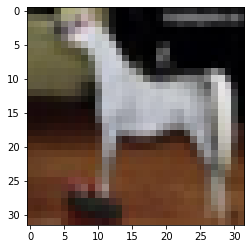

In [7]:
def imshow(img):
    img = img / 2 + 0.5 # un-normalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

imshow(samples[1])

In [8]:
# setup model

class MyCNN(nn.Module):

    def __init__(self):

        super(MyCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 6, 5)
        # 3 -> 3 channels
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # 16 * 5 * 5 -> must be fixed
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = MyCNN().to(device)

In [9]:
# setup loss, optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=learning_rate)

In [10]:
n_total_steps = len(train_loader)

for epoch in range(num_epochs):

    for i, (images, labels) in enumerate(train_loader):

        images = images.to(device)
        labels = labels.to(device)

        # forward pass
        pred_labels = model(images)
        loss = criterion(pred_labels, labels)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 1000 == 0:
            print(f"epoch: {epoch+1}/{num_epochs}, step: {i+1}/{n_total_steps}, loss: {loss.item():.4f}")

E:\OpenSoftware\miniconda\envs\ml_project\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch: 1/4, step: 1/12500, loss: 2.3811
epoch: 1/4, step: 1001/12500, loss: 2.3299
epoch: 1/4, step: 2001/12500, loss: 2.3243
epoch: 1/4, step: 3001/12500, loss: 2.2863
epoch: 1/4, step: 4001/12500, loss: 2.3008
epoch: 1/4, step: 5001/12500, loss: 2.2961
epoch: 1/4, step: 6001/12500, loss: 2.2301
epoch: 1/4, step: 7001/12500, loss: 2.2989
epoch: 1/4, step: 8001/12500, loss: 2.2517
epoch: 1/4, step: 9001/12500, loss: 2.4101
epoch: 1/4, step: 10001/12500, loss: 2.2153
epoch: 1/4, step: 11001/12500, loss: 2.0035
epoch: 1/4, step: 12001/12500, loss: 2.1404
epoch: 2/4, step: 1/12500, loss: 2.1014
epoch: 2/4, step: 1001/12500, loss: 1.9343
epoch: 2/4, step: 2001/12500, loss: 2.4144
epoch: 2/4, step: 3001/12500, loss: 1.6064
epoch: 2/4, step: 4001/12500, loss: 1.9774
epoch: 2/4, step: 5001/12500, loss: 2.2034
epoch: 2/4, step: 6001/12500, loss: 1.5898
epoch: 2/4, step: 7001/12500, loss: 1.5233
epoch: 2/4, step: 8001/12500, loss: 1.3613
epoch: 2/4, step: 9001/12500, loss: 1.7948
epoch: 2/4, st

In [12]:
# testing
with torch.no_grad():

    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]

    for images, labels in test_loader:

        # reshape -> same as above
        images = images.to(device)
        labels = labels.to(device)

        pred_labels = model(images)

        # pred_labels would be probabilities
        # get classes out of those prob.
        _, pred_labels = torch.max(pred_labels, dim=1)

        n_samples += labels.shape[0]
        n_correct = (pred_labels == labels).sum().item()

        for i in range(batch_size):
            label = labels[i]
            pred_label = pred_labels[i]
            if pred_label == label:
                n_class_correct[label]+=1
            n_class_samples[label]+=1

    accuracy = 100 * n_correct / n_samples
    print(f"accuracy of network: {accuracy} %")

    for i in range(10):
        accuracy = 100 * n_class_correct[i] / n_class_samples[i]
        print(f"accuracy of {classes[i]}: {accuracy} %")


accuracy of network: 0.01 %
accuracy of plane: 42.8 %
accuracy of car: 67.2 %
accuracy of bird: 20.7 %
accuracy of cat: 18.1 %
accuracy of deer: 51.5 %
accuracy of dog: 36.8 %
accuracy of frog: 65.6 %
accuracy of horse: 44.2 %
accuracy of ship: 65.9 %
accuracy of truck: 52.1 %
